In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import rec_gym
from rec_gym.wrappers import StatsWrapper, FlattenObservationsWrapper
from copy import deepcopy
from rec_gym.runner import run_experiment

In [3]:
from agents.baselines import RandomAgent, DotProdAgent, MFAgent, DotProdAgent
from agents.dqn import Qagent
from agents.ddpg import DDPGAgent
import tensorflow as tf

In [4]:
def prepare_random_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    action_size = env.unwrapped.n_rec
    agent = RandomAgent(action_size = action_size)    
    return agent, wrapped, env

def prepare_ddpg_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec


    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    agent = DDPGAgent(action_size = action_size,
                     state_dim = state_dim,
                     action_dim = action_dim,
                     gamma = .9,
                     sess = sess,
                     optimizer = tf.train.AdamOptimizer(
                         learning_rate=0.01
                     ),
                     max_tf_checkpoints_to_keep = 3,
                     experience_size = 300,
                     per = True,
                     batch_size = 64, 
                     start_steps = 400)
    sess.run(tf.global_variables_initializer())
    return agent, wrapped, env

def prepare_dqn_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec


    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    agent = Qagent(sess=sess,
                     state_dim=(state_dim,),
                     action_dim=(action_dim,),
                     epsilon=0.2,
                     action_size=action_size,
                     logdir=None,
                     replay_size=100,
                     batch_size=30)
    sess.run(tf.global_variables_initializer())
    
    return agent, wrapped, env

def prepare_dotprod_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec

    agent = DotProdAgent(n_rec=action_size)
    return agent, wrapped, env

def prepare_mf_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec

    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    agent = MFAgent(n_rec=action_size, state_dim=state_dim, action_dim=action_dim, sess=sess)
    sess.run(tf.global_variables_initializer())
    return agent, wrapped, env

In [5]:
from collections import defaultdict
# [EnvId][Agent] = Interactions
results = defaultdict(dict)

In [6]:
from tqdm import tqdm_notebook

In [7]:
envids = [
#     'MovieLens-v1', 
#    'MovieLens-v2', 
#    'MovieLens-v3', 
#    'MovieLens-v4',
    'GenRecEnv-v1',
    'GenRecEnv-v2',
    'GenRecEnv-v3'
]
agents = {
        'dotprod' : lambda x : prepare_dotprod_agent_and_env(x),
        'random' : lambda x : prepare_random_agent_and_env(x),
        'dqn'    : lambda x : prepare_dqn_agent_and_env(x),
        #'ddpg'   : lambda x : prepare_ddpg_agent_and_env(x),
        'mf_agent' : lambda x : prepare_mf_agent_and_env(x),
    }
n_steps = [ 
#     4000, 
#     4000, 
#     16000, 
#     16000, 
    300, 
    300, 
    300
]

for envid, n_step in tqdm_notebook(zip(envids, n_steps), leave=True, position=0):

    base_env = StatsWrapper(gym.make(envid))
    base_env.unwrapped.n_rec

    for agent_name, prepare in agents.items():
        agent, wrapped, env = prepare(base_env)
        run_experiment(wrapped, agent, t_train=n_step, t_test=0)
        
        results[envid][agent_name] = env.interactions

/home/anton/anaconda3/envs/datascience/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'rec_gym.wrappers.flatten_observation_wrapper.FlattenObservationsWrapper'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 300/300 [00:05<00:00, 60.04it/s]
0it [00:00, ?it/s]
100%|██████████| 300/300 [00:04<00:00, 60.27it/s]
0it [00:00, ?it/s]
100%|██████████| 300/300 [00:25<00:00, 10.92it/s]
0it [00:00, ?it/s]
/home/anton/anaconda3/envs/datascience/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
100%|██████

In [8]:
# import pickle
# with open('res.pkl', 'w') as f:
#     pickle.dump(f, results)

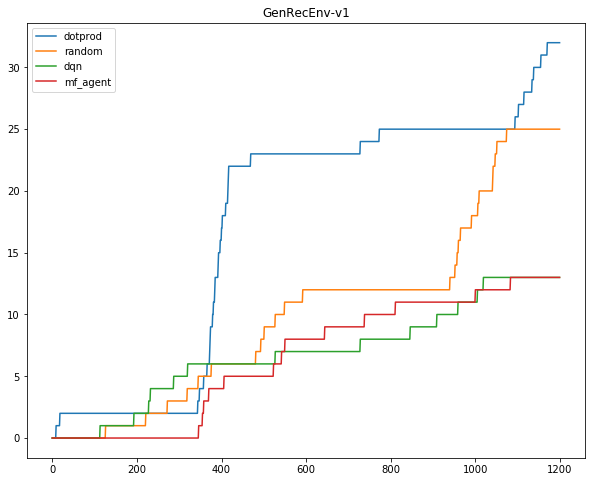

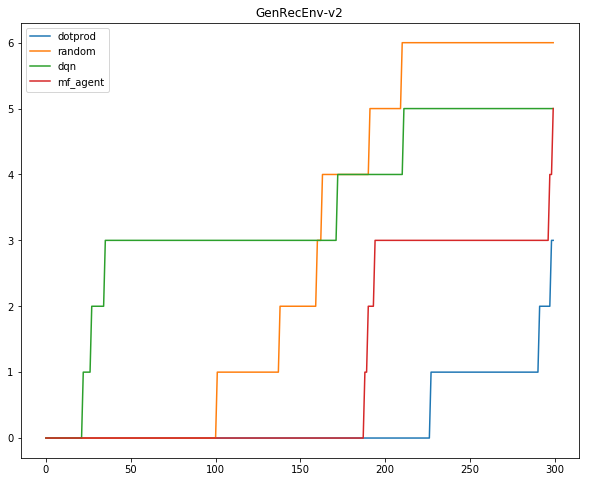

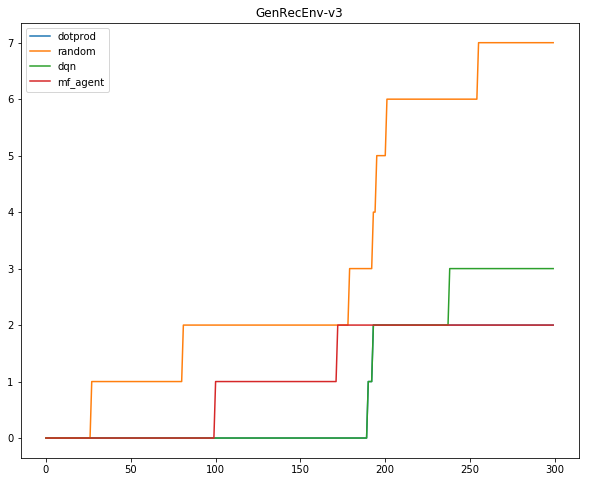

In [8]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

for envid, res in results.items():
    
    plt.figure(figsize=(10, 8))
    
    for agent_name, interactions in res.items():
        rewards = []
        for i in interactions:
            rewards.extend(i.rewards)
        
        plt.plot(np.cumsum(rewards), label=agent_name)
    
    plt.legend()
    plt.title(envid)
    
#results['MovieLens-v1']['ddpg']

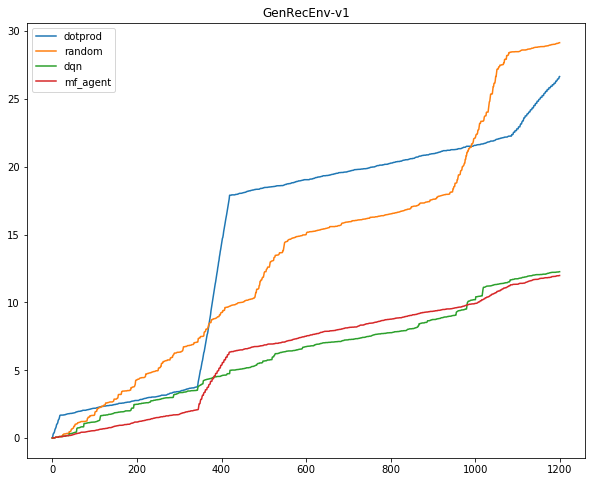

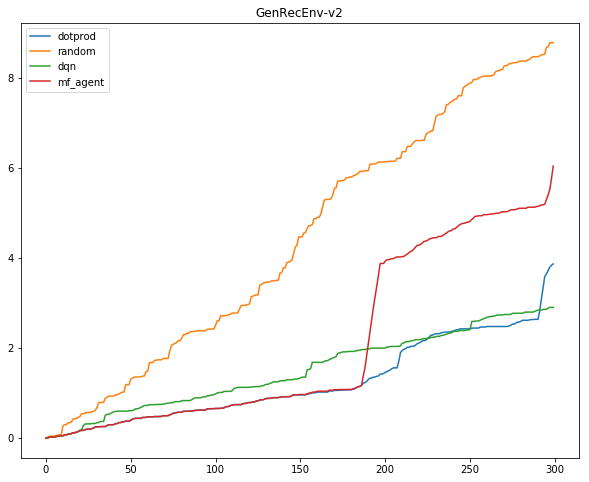

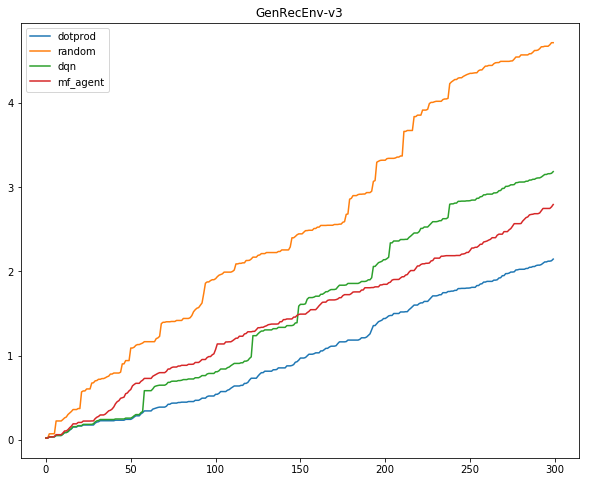

In [9]:
for envid, res in results.items():
    
    plt.figure(figsize=(10, 8))
    
    for agent_name, interactions in res.items():
        rewards = []
        for i in interactions:
            rewards.extend(i.probs)
        
        plt.plot(np.cumsum(rewards), label=agent_name)
    
    plt.legend()
    plt.title(envid)
